# Using a linear regression model to investigate the relationship between median salary and other factors in college majors

In this Jupyter notebook, we will use a linear regression model to investigate the relationship between factors such as college major category, unemployment rate, etc and the earnings of individuals with that major. We will use the [college majors dataset](https://github.com/fivethirtyeight/data/tree/master/college-majors) provided by fivethirtyeight. For more information on this dataset, please see the article about it [here](https://fivethirtyeight.com/features/the-economic-guide-to-picking-a-college-major/).

> This folder contains the data and code behind the story The Economic Guide To Picking A College Major.

> All data is from American Community Survey 2010-2012 Public Use Microdata Series.

> Download data here: http://www.census.gov/programs-surveys/acs/data/pums.html

> Documentation here: http://www.census.gov/programs-surveys/acs/technical-documentation/pums.html


This dataset contains the following columns:

Header | Description
---|---------
`Rank` | Rank by median earnings
`Major_code` | Major code, FO1DP in ACS PUMS
`Major` | Major description
`Major_category` | Category of major from Carnevale et al
`Total` | Total number of people with major
`Sample_size` | Sample size (unweighted) of full-time, year-round ONLY (used for earnings)
`Men` | Male graduates
`Women` | Female graduates
`ShareWomen` | Women as share of total
`Employed` | Number employed (ESR == 1 or 2)
`Full_time` | Employed 35 hours or more
`Part_time` | Employed less than 35 hours
`Full_time_year_round` | Employed at least 50 weeks (WKW == 1) and at least 35 hours (WKHP >= 35)
`Unemployed` | Number unemployed (ESR == 3)
`Unemployment_rate` | Unemployed / (Unemployed + Employed)
`Median` | Median earnings of full-time, year-round workers
`P25th` | 25th percentile of earnings
`P75th` | 75th percentile of earnings
`College_jobs` | Number with job requiring a college degree
`Non_college_jobs` | Number with job not requiring a college degree
`Low_wage_jobs` | Number in low-wage service jobs


## Exploratoy Data Analysis

### Importing the libraries

In [1]:
import fsspec
import pandas as pd
import numpy as np
import seaborn as sns
import janitor
import matplotlib.pyplot as plt
from adjustText import adjust_text
import statsmodels.api as sm
from statsmodels.formula.api import wls
import sklearn.model_selection

### Loading the dataset

In [2]:
# instantiate an fsspec filesystem object w/ caching enabled
fs = fsspec.filesystem("filecache", target_protocol="https", cache_storage="/tmp/files")

# load the data from the remote URL
url = (
    "https://raw.githubusercontent.com/fivethirtyeight/data/master/college-majors/recent-grads.csv"
)
df = pd.read_csv(fs.open(url))
df.head()

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972


### Data Cleaning


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rank                  173 non-null    int64  
 1   Major_code            173 non-null    int64  
 2   Major                 173 non-null    object 
 3   Total                 172 non-null    float64
 4   Men                   172 non-null    float64
 5   Women                 172 non-null    float64
 6   Major_category        173 non-null    object 
 7   ShareWomen            172 non-null    float64
 8   Sample_size           173 non-null    int64  
 9   Employed              173 non-null    int64  
 10  Full_time             173 non-null    int64  
 11  Part_time             173 non-null    int64  
 12  Full_time_year_round  173 non-null    int64  
 13  Unemployed            173 non-null    int64  
 14  Unemployment_rate     173 non-null    float64
 15  Median                1


- The dataset contains 173 rows and 21 columns with most of the columns being numeric.
- The column names are in a mixed case format. We will convert them to lowercase for ease of use
- Luckily, there are very few missing values in the dataset. We can drop the rows with missing values. Additionally


In [4]:
df = df.dropna().clean_names().remove_empty()
# set major column values to title case
df["major"] = df["major"].str.title()

### The Correlation Matrix as heatmap 


/tmp/ipykernel_1320663/2613703272.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


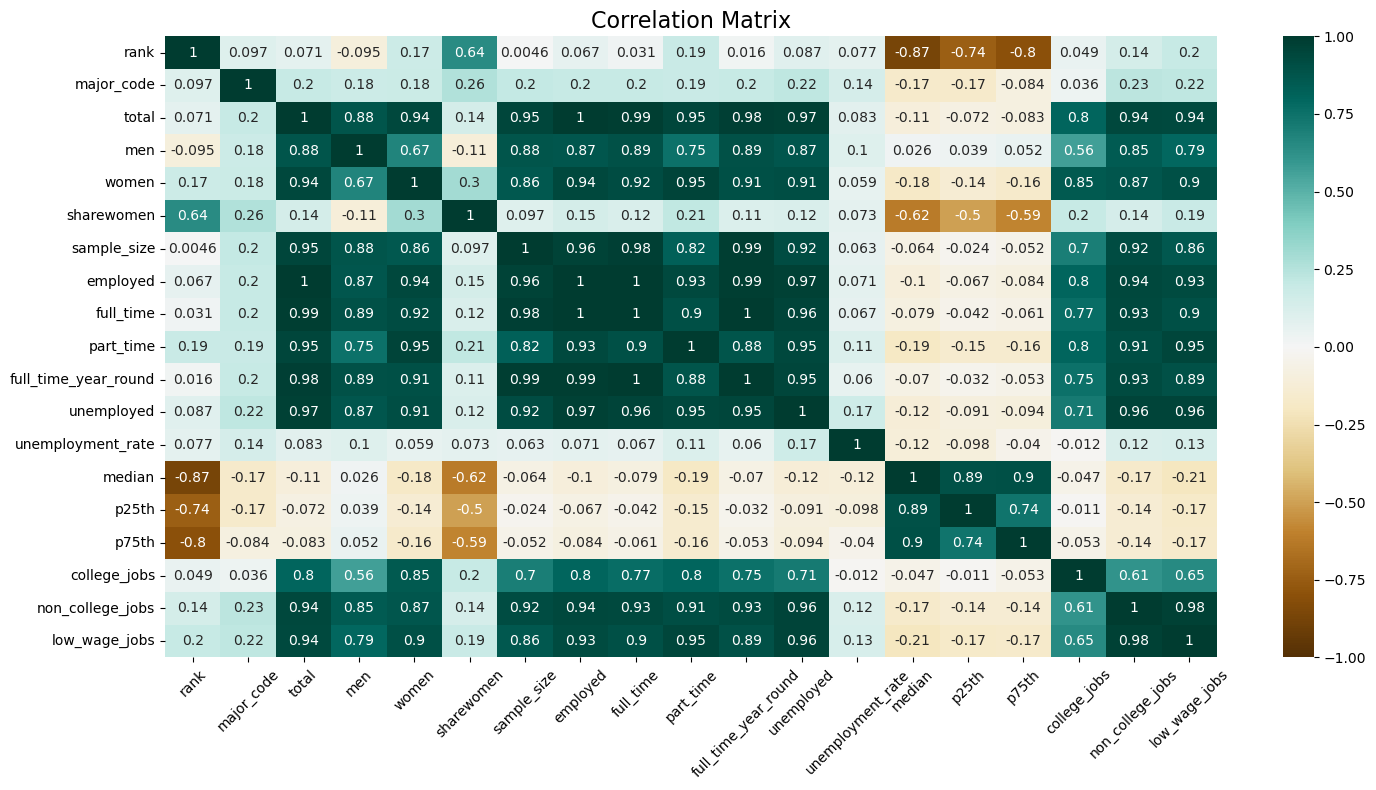

In [5]:
corr = df.corr()

plt.figure(figsize=(15, 8))
p = sns.heatmap(corr, vmax=1, vmin=-1, annot=True, cmap='BrBG')
p.set_title('Correlation Matrix', fontdict={'fontsize': 16})
plt.xticks(rotation=45)
plt.tight_layout()

The correlation matrix plot shows that there's a negative correlation between share of women and median salary. Later we will use a linear regression model to confirm this relationship and to determine whether it is statistically significant.


### Distribution of Median Earnings

let's start by looking at the distribution of the median salaries. 


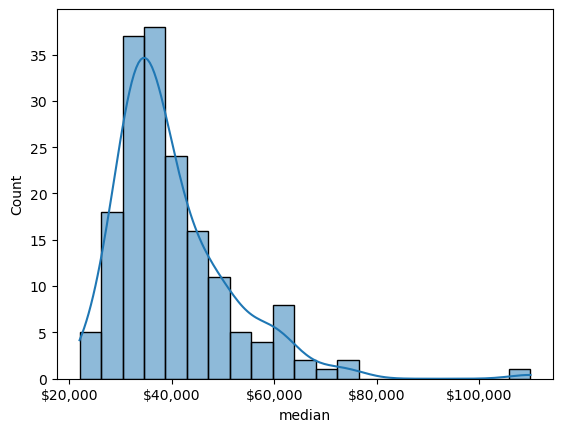

In [6]:
ax = sns.histplot(data=df, x="median", kde=True)
ax.xaxis.set_major_formatter('${x:,.0f}')

It appears that the median salary for recent college graduates is around $35,000. The distribution is skewed to the right, with a few outliers on the high end.




### Variability in the median salary depending on the sample size 

The plot below shows the median salary for each major category. We can see that the median salary for majors with a small sample size is more variable. The median salary for majors with a large sample size is more stable. As a result, we can drop the majors with a small sample size to get a more stable estimate of the median salary for each major category.

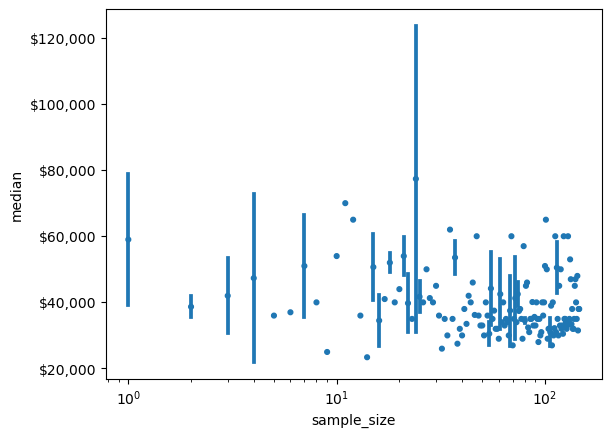

In [7]:
ax = sns.pointplot(
    data=df, y="median", x="sample_size", join=False, markers="o", scale=0.5, errorbar="sd"
)
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xscale('log')

### What categories of majors have the highest and lowest median salaries?


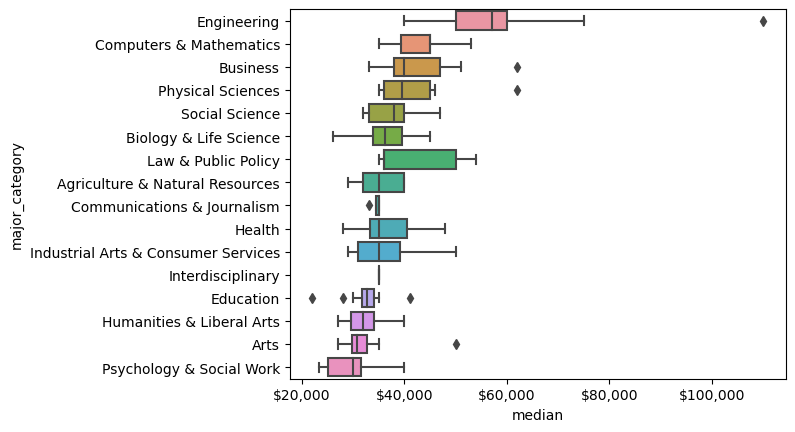

In [8]:
order = df.groupby("major_category")['median'].median().sort_values(ascending=False).index
ax = sns.boxplot(data=df, x="median", y="major_category", order=order)
ax.xaxis.set_major_formatter('${x:,.0f}')

This plot shows the distribution of median salaries by major category. The plot is sorted by the median salary of each major category. We can see that the median salary for engineering majors is the highest, followed by business and computer science. The lowest median salary is for the psychology and social work category.


### What are the highest paying majors?

In [9]:
majors_data = df[
    ['major', 'major_category', 'median', 'p25th', 'p75th', 'sample_size']
].sort_values(by='median', ascending=False)

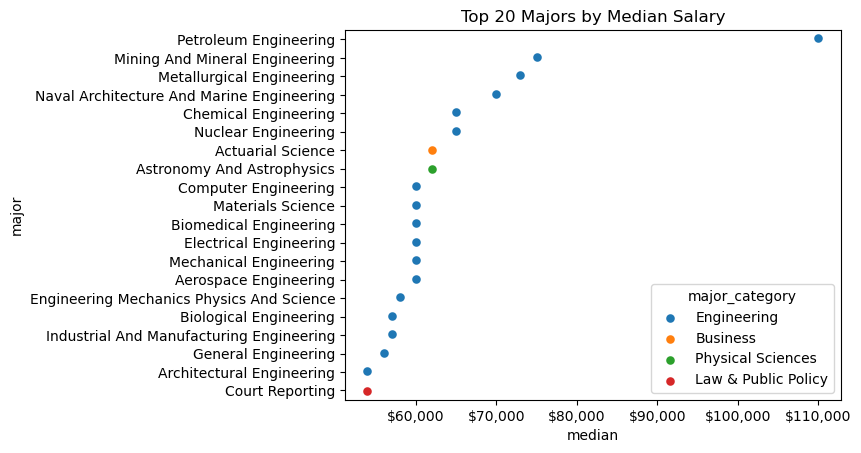

In [10]:
ax = sns.pointplot(
    data=majors_data.head(20),
    x="median",
    y="major",
    hue="major_category",
    dodge=True,
    join=False,
    markers="o",
    scale=0.7,
)
ax.set_title("Top 20 Majors by Median Salary")
ax.xaxis.set_major_formatter('${x:,.0f}');

The highest paying majors are petroleum engineering, mining and mineral engineering and other related majors. Petroleum engineering major appears to have the majority of outliers on the high end of the salary distribution. The plot also shows that most of the majors in the top 20 are engineering majors.

As mentioned earlier, the sample size for some of the majors is small. We can drop the majors with a small sample size to get a more stable estimate of the median salary for each major category. The plot below shows the median salary for each major category after dropping the majors with a small sample size. We can see that the median salary for engineering majors is the highest, followed by computer science and business.

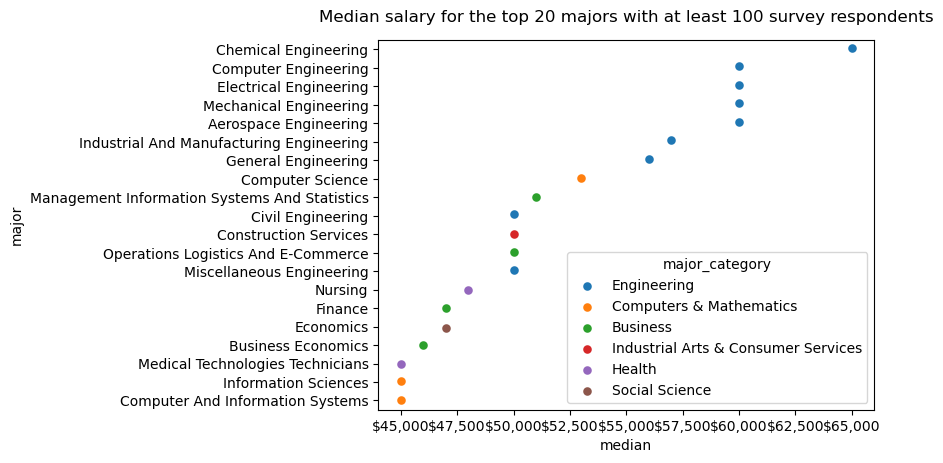

In [11]:
ax = sns.pointplot(
    data=majors_data.filter_on('sample_size>=100').head(20),
    x="median",
    y="major",
    hue="major_category",
    dodge=True,
    join=False,
    markers="o",
    scale=0.7,
)

ax.text(
    0.5,
    1.05,
    "Median salary for the top 20 majors with at least 100 survey respondents",
    horizontalalignment="center",
    fontsize=12,
    transform=ax.transAxes,
)
ax.xaxis.set_major_formatter('${x:,.0f}');

### What are the lowest paying majors?



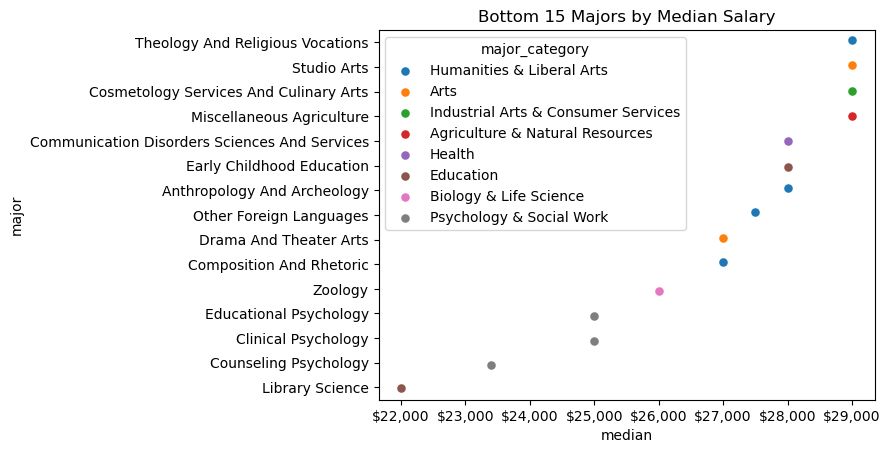

In [12]:
ax = sns.pointplot(
    data=majors_data.tail(15),
    x="median",
    y="major",
    hue="major_category",
    dodge=True,
    join=False,
    markers="o",
    scale=0.7,
)
ax.set_title("Bottom 15 Majors by Median Salary")
ax.xaxis.set_major_formatter('${x:,.0f}');

The median salary for the lowest paying majors is around $25,000 - $28,000. The lowest paying majors are in the psychology & social work category. 

### What are the most common major categories?

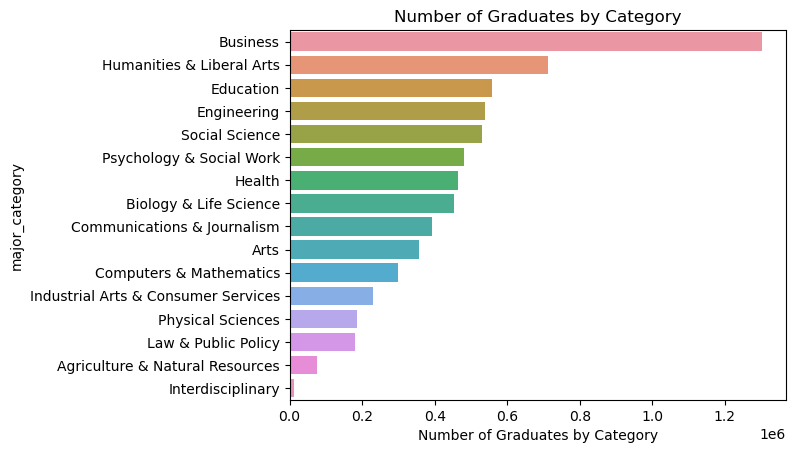

In [13]:
category_count = df.groupby("major_category")['total'].sum().sort_values(ascending=False)
ax = sns.barplot(y=category_count.index, x=category_count.values)
ax.set_title("Number of Graduates by Category")
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xlabel("Number of Graduates by Category");

### How does gender breakdown relate to the median salary?

To look at the gender breakdown and how it relates to the median salary, we are going to compute some statistics for a few columns. The statistics are computed for each major category. 

In [14]:
def compute_weighted_median(group):
    sample_size = group['sample_size']
    data = group['median']
    return ((sample_size * data).sum() / sample_size.sum()).round(2)


grouped = df.groupby("major_category")[['total', 'men', 'women', 'median', 'sample_size']]
data = grouped.agg({'total': 'sum', 'men': 'sum', 'women': 'sum'})

data['median'] = grouped.apply(compute_weighted_median)
data['share_women'] = (data['women'] / data['total']).round(2)
data = data.sort_values(by='share_women', ascending=False)
data

,total,men,women,median,share_women
major_category,,,,,
Health,463230.0,75517.0,387713.0,43693.74,0.84
Education,559129.0,103526.0,455603.0,32363.52,0.81
Psychology & Social Work,481007.0,98115.0,382892.0,31234.40,0.80
Interdisciplinary,12296.0,2817.0,9479.0,35000.00,0.77
Communications & Journalism,392601.0,131921.0,260680.0,34738.24,0.66
Arts,357130.0,134390.0,222740.0,32045.86,0.62
Humanities & Liberal Arts,713468.0,272846.0,440622.0,32192.32,0.62
Biology & Life Science,453862.0,184919.0,268943.0,34378.55,0.59
Industrial Arts & Consumer Services,229792.0,103781.0,126011.0,34185.59,0.55


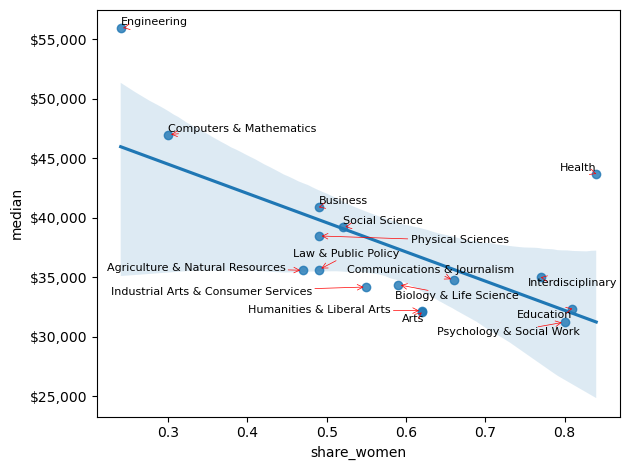

In [15]:
ax = sns.regplot(data=data, y="median", x="share_women")
ax.yaxis.set_major_formatter('${x:,.0f}')
texts = [
    ax.text(
        x,
        y,
        name,
        fontsize=8,
    )
    for x, y, name in zip(data['share_women'], data['median'], data.index)
]
adjust_text(
    texts,
    only_move={'points': 'y', 'texts': 'y'},
    arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
)
plt.tight_layout()

The plot above reveals a couple of insights:

- Health and Education are 80% women
- Computer science and Engineering are 20%-30% women
- Engineering and computers & mathematics are outliers in two aspects:
  - higher salaries
  - small women share

- Health is an outlier in two aspects:
  - lower salaries
  - high women share 

- The median salary is negatively correlated with the share of women. We should emphasize that this correlation doesn't necessary tell us anything about the causal relationship between the two variables.

### Weighted Linear Regression Model


Because of the variability in sample size of graduates that were surveyed, we are going to use a weighted linear regression model. A weighted least squares (WLS) regression model is a variant of linear regression that allows for unequal variances in the error terms (i.e. the differences between the predicted values and the true values) by assigning different weights to each observation.


The model will be weighted by the sample size. This means that the model will be less sensitive to the majors with a small sample size.

In [16]:
categorical_columns = list({'major_category', 'major'})
numerical_columns = list(
    {
        'college_jobs',
        'sharewomen',
        'unemployment_rate',
        'part_time',
        'full_time',
        'employed',
        'non_college_jobs',
        'low_wage_jobs',
    }
)

data, test_data = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)
data

,rank,major_code,major,total,men,women,major_category,sharewomen,sample_size,employed,...,part_time,full_time_year_round,unemployed,unemployment_rate,median,p25th,p75th,college_jobs,non_college_jobs,low_wage_jobs
101,103,5503,Criminology,19879.0,10031.0,9848.0,Social Science,0.495397,214,16181,...,4543,10548,1743,0.097244,35000,25000,45000,3373,10605,1895
56,58,6200,General Business,234590.0,132238.0,102352.0,Business,0.436302,2380,190183,...,36241,138299,14946,0.072861,40000,30000,55000,29334,100831,27320
42,44,5007,Physics,32142.0,23080.0,9062.0,Physical Sciences,0.281936,142,25302,...,8721,14389,1282,0.048224,45000,30000,68000,18674,4576,1823
82,84,3602,Botany,1329.0,626.0,703.0,Biology & Life Science,0.528969,9,1010,...,169,740,0,0.000000,37000,26000,40000,677,184,56
65,67,2504,Mechanical Engineering Related Technologies,4790.0,4419.0,371.0,Engineering,0.077453,71,4186,...,247,3607,250,0.056357,40000,27000,52000,1861,2121,406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,73,5000,Physical Sciences,1436.0,894.0,542.0,Physical Sciences,0.377437,10,1146,...,437,653,42,0.035354,40000,30000,55000,530,465,269
106,108,1303,Natural Resources Management,13773.0,8617.0,5156.0,Agriculture & Natural Resources,0.374356,152,11797,...,2613,6954,842,0.066619,35000,25000,42000,4333,5808,1405
14,15,2409,Engineering Mechanics Physics And Science,4321.0,3526.0,795.0,Engineering,0.183985,30,3608,...,811,2004,23,0.006334,58000,25000,74000,2439,947,263
92,94,1901,Communications,213996.0,70619.0,143377.0,Communications & Journalism,0.669999,2394,179633,...,49889,116251,14602,0.075177,35000,27000,45000,40763,97964,27440


In [17]:
model = wls("median ~ sharewomen", data=data, weights=data.sample_size).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 median   R-squared:                       0.381
Model:                            WLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     83.03
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           9.73e-16
Time:                        08:31:35   Log-Likelihood:                -1475.0
No. Observations:                 137   AIC:                             2954.
Df Residuals:                     135   BIC:                             2960.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.279e+04   1583.319     33.340      0.000    4.97e+04    5.59e+04
sharewomen -2.332e+04   2559.312     -9.112      0.000   -2.84e+04   -1.83e+04
==============================================================================
Omnibus:                      114.683   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1625.499
Skew:                           2.788   Prob(JB):                         0.00
Kurtosis:                      18.927   Cond. No.                         6.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The model tells us that if a major went from 0% to 100% of women, the expected median salary would decrease by $236.50. This is a negative correlation between the share of women and the median salary. With a p-value of ~0.000`, the results are statistically significant.

- The adjusted r-squared is 0.35. This means that the model explains 35% of the variability in the median salary. This is a relatively low value. This means that there are other factors that are not included in the model that explain the variability in the median salary. 

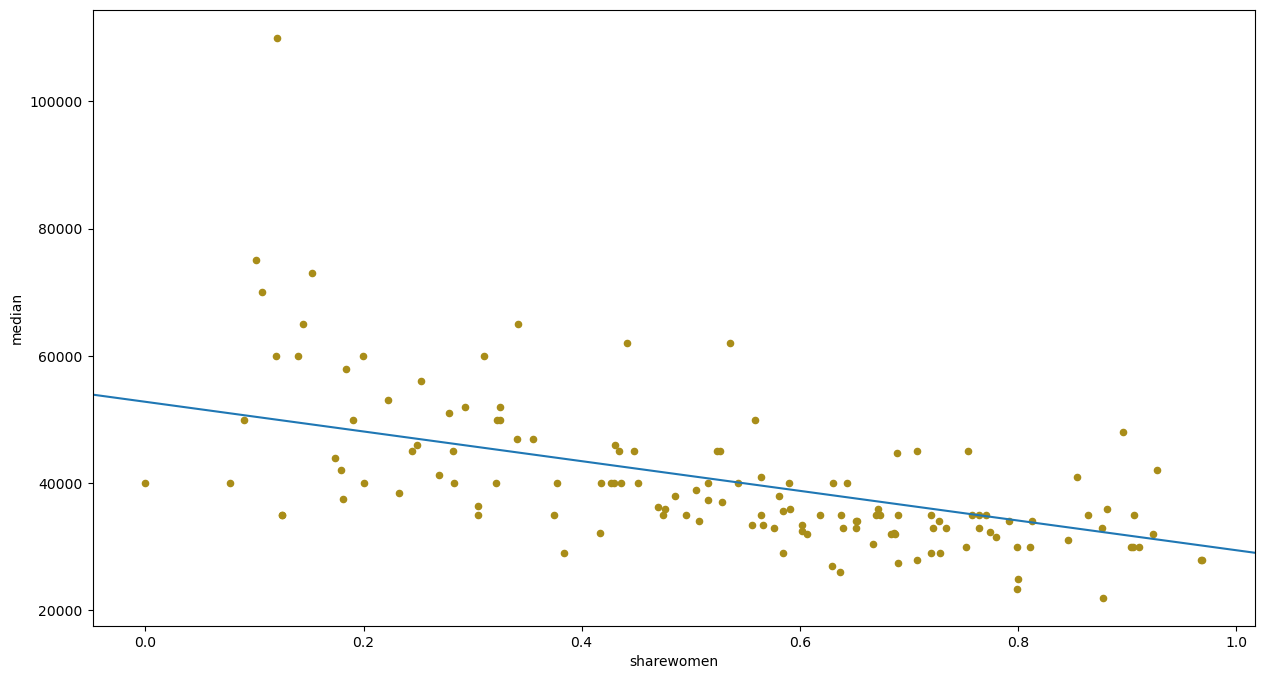

In [18]:
ax = data.plot.scatter(y='median', x='sharewomen', c='#a98d19', figsize=(15, 8))
sm.graphics.abline_plot(model_results=model, ax=ax);

### Weighted Multiple Linear Regression Model 

In this section, we are going to use the best subset selection method to find the best model that explains the variability in the median salary. The best subset selection method is a greedy algorithm that iteratively adds or removes variables from the model. The model is evaluated using the adjusted r-squared. The model with the highest adjusted r-squared is selected.

In [19]:
categorical_columns = list({'major_category'})
numerical_columns = list(
    {
        'college_jobs',
        'sharewomen',
        'unemployment_rate',
        'part_time',
        'full_time',
        'employed',
        'non_college_jobs',
        'low_wage_jobs',
    }
)

allowed_factors = numerical_columns + categorical_columns

best = ['', 0]
train_median_1 = None
adjr2_train = []
adjr2_test = []

for factor in allowed_factors:
    if factor in categorical_columns:
        factor = f'C({factor})'
    model = wls(formula=f'median~{factor}', data=data, weights=data.sample_size).fit()
    print(factor, model.rsquared_adj)

    if model.rsquared_adj > best[1]:
        best = [factor, model.rsquared_adj]
        train_median_1 = model

model_test = wls(
    formula=train_median_1.model.formula, data=test_data, weights=test_data.sample_size
).fit()
adjr2_test.append(model_test.rsquared_adj)
adjr2_train.append(best[1])
best_factors = [best[0]]
print(f'\nbest: {best_factors} : {best[1]}')

non_college_jobs 0.06207115217612169
part_time 0.058134880481222395
full_time -0.007405942790412512
sharewomen 0.3762397342037973
college_jobs -0.007044384487192357
employed -0.0034546794822749582
low_wage_jobs 0.10220527142405522
unemployment_rate 0.034386366990322825
C(major_category) 0.6507186212024225

best: ['C(major_category)'] : 0.6507186212024225


In [20]:
best = ['', 0]

for factor in list(set(allowed_factors) - set(best_factors)):
    if factor in categorical_columns:
        factor = f'C({factor})'

    model = wls(
        formula=f'{train_median_1.model.formula}+{factor}', data=data, weights=data.sample_size
    ).fit()
    print(f"{', '.join(best_factors)}, {factor}: {model.rsquared_adj}")
    if model.rsquared_adj > best[1]:
        best = [factor, model.rsquared_adj]
        train_median_2 = model

model_test = wls(
    formula=train_median_1.model.formula, data=test_data, weights=test_data.sample_size
).fit()
adjr2_test.append(model_test.rsquared_adj)
adjr2_train.append(best[1])
best_factors.append(best[0])
print(f'\nbest: {best_factors} : {best[1]}')

C(major_category), unemployment_rate: 0.6846490049436498
C(major_category), part_time: 0.6498545256218082
C(major_category), full_time: 0.6640110230895588
C(major_category), C(major_category): 0.6507186212024225
C(major_category), sharewomen: 0.7017238031553799
C(major_category), college_jobs: 0.6841640372202042
C(major_category), employed: 0.6609557092260294
C(major_category), low_wage_jobs: 0.6507977270271248
C(major_category), non_college_jobs: 0.6489751295145836

best: ['C(major_category)', 'sharewomen'] : 0.7017238031553799


In [21]:
best = ['', 0]

for factor in list(set(allowed_factors) - set(best_factors)):
    if factor in categorical_columns:
        factor = f'C({factor})'

    model = wls(
        formula=f'{train_median_2.model.formula}+{factor}', data=data, weights=data.sample_size
    ).fit()
    print(f"{', '.join(best_factors)}, {factor}: {model.rsquared_adj}")
    if model.rsquared_adj > best[1]:
        best = [factor, model.rsquared_adj]
        train_median_3 = model

model_test = wls(
    formula=train_median_2.model.formula, data=test_data, weights=test_data.sample_size
).fit()
adjr2_test.append(model_test.rsquared_adj)
adjr2_train.append(best[1])
best_factors.append(best[0])
print(f'\nbest: {best_factors} : {best[1]}')

C(major_category), sharewomen, non_college_jobs: 0.7012008655279767
C(major_category), sharewomen, part_time: 0.7022997709567773
C(major_category), sharewomen, full_time: 0.7156474632218977
C(major_category), sharewomen, C(major_category): 0.7017238031553799
C(major_category), sharewomen, college_jobs: 0.7447477036471256
C(major_category), sharewomen, employed: 0.7133621863580224
C(major_category), sharewomen, low_wage_jobs: 0.7022547308325919
C(major_category), sharewomen, unemployment_rate: 0.734062599499645

best: ['C(major_category)', 'sharewomen', 'college_jobs'] : 0.7447477036471256


In [22]:
best = ['', 0]

for factor in list(set(allowed_factors) - set(best_factors)):
    if factor in categorical_columns:
        factor = f'C({factor})'

    model = wls(
        formula=f'{train_median_3.model.formula}+{factor}', data=data, weights=data.sample_size
    ).fit()
    print(f"{', '.join(best_factors)}, {factor}: {model.rsquared_adj}")
    if model.rsquared_adj > best[1]:
        best = [factor, model.rsquared_adj]
        train_median_4 = model

model_test = wls(
    formula=train_median_3.model.formula, data=test_data, weights=test_data.sample_size
).fit()
adjr2_test.append(model_test.rsquared_adj)
adjr2_train.append(best[1])
best_factors.append(best[0])
print(f'\nbest: {best_factors} : {best[1]}')

C(major_category), sharewomen, college_jobs, non_college_jobs: 0.7943493738146623
C(major_category), sharewomen, college_jobs, part_time: 0.7799688207711275
C(major_category), sharewomen, college_jobs, full_time: 0.7524437363937846
C(major_category), sharewomen, college_jobs, C(major_category): 0.7447477036471256
C(major_category), sharewomen, college_jobs, employed: 0.7576044132842907
C(major_category), sharewomen, college_jobs, low_wage_jobs: 0.7983143610799392
C(major_category), sharewomen, college_jobs, unemployment_rate: 0.7682281303306508

best: ['C(major_category)', 'sharewomen', 'college_jobs', 'low_wage_jobs'] : 0.7983143610799392


In [23]:
best = ['', 0]

for factor in list(set(allowed_factors) - set(best_factors)):
    if factor in categorical_columns:
        factor = f'C({factor})'

    model = wls(
        formula=f'{train_median_4.model.formula}+{factor}', data=data, weights=data.sample_size
    ).fit()
    print(f"{', '.join(best_factors)}, {factor}: {model.rsquared_adj}")
    if model.rsquared_adj > best[1]:
        best = [factor, model.rsquared_adj]
        train_median_5 = model

model_test = wls(
    formula=train_median_4.model.formula, data=test_data, weights=test_data.sample_size
).fit()
adjr2_test.append(model_test.rsquared_adj)
adjr2_train.append(best[1])
best_factors.append(best[0])
print(f'\nbest: {best_factors} : {best[1]}')

C(major_category), sharewomen, college_jobs, low_wage_jobs, non_college_jobs: 0.7967800478771324
C(major_category), sharewomen, college_jobs, low_wage_jobs, part_time: 0.8002938782712364
C(major_category), sharewomen, college_jobs, low_wage_jobs, full_time: 0.8111864306578782
C(major_category), sharewomen, college_jobs, low_wage_jobs, C(major_category): 0.7983143610799392
C(major_category), sharewomen, college_jobs, low_wage_jobs, employed: 0.8121189439375565
C(major_category), sharewomen, college_jobs, low_wage_jobs, unemployment_rate: 0.8054857764002398

best: ['C(major_category)', 'sharewomen', 'college_jobs', 'low_wage_jobs', 'employed'] : 0.8121189439375565


Let's plot the adjusted r-squared for each model:

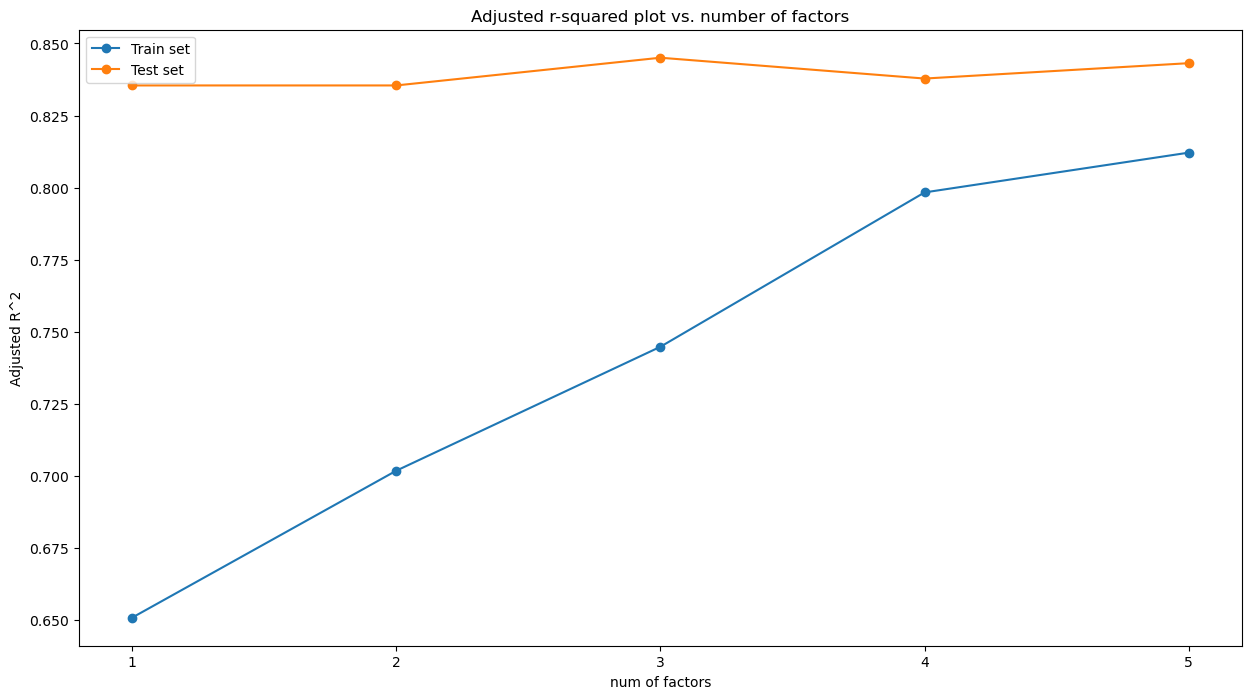

In [24]:
x = range(1, len(adjr2_train) + 1)
y1 = adjr2_train
y2 = adjr2_test

plt.figure(figsize=(15, 8))
plt.plot(x, y1, label='Train set', marker='o')
plt.plot(x, y2, label='Test set', marker='o')
plt.xlabel('num of factors')
plt.ylabel('Adjusted R^2')
plt.title('Adjusted r-squared plot vs. number of factors')
plt.legend()
plt.xticks(x)
plt.show()


According to the plot, the  adjusted R-squared increases significantly for a model with 4 predictors. This means that the model with 4 predictors is the best model. Let's look at the predictors for this model:

- `major_category`: Women as share of total graduate respondents
- `sharewomen`: Category of major from Carnevale et al
- `college_jobs`: Number with job requiring a college degree
- `low_wage_jobs`: Number in low-wage service jobs




`best: ['C(major_category)', 'sharewomen', 'college_jobs', 'low_wage_jobs'] : 0.7983143610799392`



In [25]:
train_median_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 median   R-squared:                       0.825
Model:                            WLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     30.91
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           3.14e-36
Time:                        08:31:35   Log-Likelihood:                -1388.4
No. Observations:                 137   AIC:                             2815.
Df Residuals:                     118   BIC:                             2870.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                 4.503e+04   2612.990     17.234      0.000    3.99e+04    5.02e+04
C(major_category)[T.Arts]                                 2225.9704   2826.151      0.788      0.432   -3370.577    7822.518
C(major_category)[T.Biology & Life Science]                162.6320   2777.077      0.059      0.953   -5336.737    5662.001
C(major_category)[T.Business]                             9334.6306   2407.445      3.877      0.000    4567.235    1.41e+04
C(major_category)[T.Communications & Journalism]          6021.6221   2693.900      2.235      0.027     686.966    1.14e+04
C(major_category)[T.Computers & Mathematics]              5522.2337   2760.288      2.001      0.048      56.112     1.1e+04
C(major_category)[T.Education]                            -635.8094   2749.631     -0.231      0.818   -6080.827    4809.209
C(major_category)[T.Engineering]                          1.319e+04   2645.844      4.985      0.000    7949.726    1.84e+04
C(major_category)[T.Health]                               6229.9322   2968.010      2.099      0.038     352.465    1.21e+04
C(major_category)[T.Humanities & Liberal Arts]           -1066.2507   2666.552     -0.400      0.690   -6346.750    4214.249
C(major_category)[T.Industrial Arts & Consumer Services]   958.3058   3009.303      0.318      0.751   -5000.934    6917.546
C(major_category)[T.Interdisciplinary]                    4801.5814   6528.873      0.735      0.464   -8127.364    1.77e+04
C(major_category)[T.Law & Public Policy]                  2667.1249   2801.033      0.952      0.343   -2879.684    8213.934
C(major_category)[T.Physical Sciences]                    2282.7709   3059.058      0.746      0.457   -3774.997    8340.538
C(major_category)[T.Psychology & Social Work]             2728.8066   3164.098      0.862      0.390   -3536.969    8994.582
C(major_category)[T.Social Science]                       6040.3942   2582.406      2.339      0.021     926.527    1.12e+04
sharewomen                                               -1.953e+04   3005.768     -6.498      0.000   -2.55e+04   -1.36e+04
college_jobs                                                 0.1046      0.014      7.595      0.000       0.077       0.132
low_wage_jobs                                               -0.3002      0.053     -5.710      0.000      -0.404      -0.196
==============================================================================
Omnibus:                       34.686   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.764
Skew:                           0.771   Prob(JB):                     1.83e-33
Kurtosis:        


### Takeaways and conclusion

In this project, we analyzed the job outcomes of students who graduated from college between 2010 and 2012. Using visualizations, we explored the distributions of median salaries in respect to other factors such as gender, major category. We also determined the best model that explains the variability in the median salary. The model explains 80% of the variability in the median salary. This means that the model with four predictors (`sharewomen`, `major_category`, `college_jobs`, `low_wage_jobs`) is a good fit for the data. The p-values for all the predictors are less than 0.05. This means that the results are statistically significant. 


For future work, we can use other machine learning models to predict the median salary and compare the results with the weighted linear regression model that we used in this project. 
